Wiley Winters<br>
Week 6 Lab01 &ndash; K-Means and Hierarchical Clustering<br>
2023-OCT-1<br>

-------------------------------------------------------------------------------
## Assignment for Week 6 - K-Means and Hierarchical Clustering

### Exerise:
#### KMeans and Hierarchial Clustering

Collect data from twitter using your choice of hashtag (at least 1000 tweets). 
To gather your Twitter data, I would recommend using the python library tweepy.<br>
Note: Reddit data can be used instead of Twitter data for this assignment.

- You will use both K-Means and HCA to cluster the collected data
- Draw a dendrogram
- Identify number of optimum clusters, and justify how do you pick number of clusters
- List the top 10 most frequent words
- Visualize using wordclouds
- Summarize your findings

### Deliverables:

Upload your notebook's .ipynb file.
   
**Important:** Make sure your provide complete and thorough explanations for all of your analysis. You need to defend your thought processes and reasoning.

-------------------------------------------------------------------------------
**Import Required Packages and Libraries**

In [1]:
# Standard Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys

# Read sqlite3 database file
import sqlite3

# Text processing and preparation
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords, words

# Clustering modeling and dimension reduction
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import linkage, dendrogram

# Model testing and visualization
from sklearn import metrics
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud

# Make plots pretty
plt.style.use('ggplot')

**Define Functions to be Used in this Notebook**

Process text function to perform basic preprocessing on text features.  I changed this function to use lemmatization instead of stemming.  While stemming can be faster to perform, lemmatization actually reduces the word-forms to linguistically valid lemmas.

In [2]:
def process_text(text):
    if isinstance(text, str):
        text = text.lower() # Convert all to lower case
        # Remove punctuation
        text = ''.join([char for char in text if char not in string.punctuation])
        text = ''.join([char for char in text if not char.isdigit()])  # Remove numbers
        # In some instances, I've run into issues with extra spaces.
        text = text.strip()
        # Remove stop words and apply lemmatizer
        stop = stopwords.words('english')
        wnl = WordNetLemmatizer()
        text = ' '.join([wnl.lemmatize(word) for word in text.split() if word not in \
                         stop])

        return text
    else:
        return ' '

I chose to download **Reddit** submissions and their associated comments.  Since the relationship between submissions and comments are one to many, I decided to store the data in a *sqlite3* datafile.  This will allow me to query the data using standard SQL statements that allows for one to many SQL joins.

The code below creates a connection to the datafile and then queries it based on criteria I have chosen.  A pandas dataframe is created from the query.

Since I believe the purpose of the lab is to cluster words, I will only load text features.

In [3]:
conn = sqlite3.connect('space.sqlite')  # Create the database connection object

reddit_df = pd.read_sql_query('SELECT id, created_utc, title, author, n_comments, ' \
                              'score, ratio, text, comment_id, comment_utc, ' \
                              'comment_author, body, comment_score ' \
                              'FROM posts, comments WHERE posts.id = comments.link_id ' \
                              'AND n_comments > 0', conn)
# Take a quick peek at the data
reddit_df.sample(5)

,id,created_utc,title,author,n_comments,score,ratio,text,comment_id,comment_utc,comment_author,body,comment_score
115255,coppj8,1.565482e+09,"A dramatic, closeup look at Thursday’s Atlas V...",johnkphotos,675,55327,0.96,,ewm501e,1.565543e+09,church1990,Wow!!!!!,1
362397,ont578,1.626749e+09,I unwrapped Neil Armstrong’s visor to 360 sphe...,rg1213,742,29333,0.95,I took this https://i.imgur.com/q4sjBDo.jpg fa...,h5uc2hy,1.626758e+09,doctor91,Man that movie stage looked realistic for sure...,2
58424,9lmgi3,1.538748e+09,Proton-M launch goes horribly wrong,RocketRundown,3192,67572,0.91,,e78cm7a,1.538766e+09,MonoShadow,Ours(no clarification) are fucked. How did it ...,5
42675,800o0l,1.519517e+09,I photographed myself looking at the Milky Way...,marcuscotephoto,939,74316,0.86,,dusexby,1.519532e+09,glox023,Idk why but this comment thread has been so wh...,36
327161,s5b56v,1.642337e+09,I finally caught the ISS transiting the Moon! ...,lndoraptor28,251,31562,0.97,,hsycn3i,1.642369e+09,TheRadioFrontiers,Truly wonderful shot! Well done!,2


The dataset has two features that are datetime datatypes, but the format is in UNIX epoch seconds time.  I will convert them to something a little more readable.

In [4]:
reddit_df['created_utc'] = pd.to_datetime(reddit_df['created_utc'], unit='s')
reddit_df['comment_utc'] = pd.to_datetime(reddit_df['comment_utc'], unit='s')
reddit_df.sample(5)

,id,created_utc,title,author,n_comments,score,ratio,text,comment_id,comment_utc,comment_author,body,comment_score
268299,l9bp8c,2021-01-31 12:50:37,Betelgeuse from the backyard with a tilt shift...,NightSkyFlying,392,35826,0.95,,glid9be,2021-01-31 19:24:31,MarvinLazer,We deserve it after last year.,8
137238,iltegw,2020-09-03 13:29:36,Elon Musk Says Settlers Will Likely Die on Mar...,Yzark-Tak,3894,50886,0.88,,g3v2zv7,2020-09-03 16:06:19,radusernamehere,Just wait until they hear about all these thin...,17
171288,wrtx3o,2022-08-18 20:29:39,NASA astronaut Nicole Aunapu Mann will be the ...,None,2528,45846,0.80,,ikwri5p,2022-08-19 08:43:40,Zech08,A busy Marine is a safe Marine.,3
66461,q7mksu,2021-10-13 22:45:09,Shatner in Space,TotalSpaceNut,3901,64864,0.85,,hgjp6ii,2021-10-13 23:26:42,None,[removed],64
186900,7p01w1,2018-01-08 17:26:02,"Dear astrofisicists of Reddit,",francisc2003,1483,44073,0.80,I'm a portuguese 14 yo that Dreams of being an...,dsezke4,2018-01-09 13:55:56,Auginis,"I'm actually so sad, seeing how much astrophys...",2


From previous experiences with this dataset, I know when a comment is removed or deleted, the `body` text is replaced with `[deleted]` or `[removed]`.  I will take a look to see if the count of those comments is significant

In [5]:
print(reddit_df[reddit_df['body'] == '[deleted]'].count())
print(reddit_df[reddit_df['body'] == '[removed]'].count())

id                8813
created_utc       8813
title             8813
author            8813
n_comments        8813
score             8813
ratio             8813
text              8813
comment_id        8813
comment_utc       8813
comment_author    8813
body              8813
comment_score     8813
dtype: int64
id                18223
created_utc       18223
title             18223
author            18223
n_comments        18223
score             18223
ratio             18223
text              18223
comment_id        18223
comment_utc       18223
comment_author    18223
body              18223
comment_score     18223
dtype: int64


The number is not significant so I will drop these rows.  Its less than 1% of the dataset.

In [6]:
indexBody = reddit_df[(reddit_df['body'] == '[deleted]') | \
                      (reddit_df['body'] =='[removed]')].index
reddit_df.drop(indexBody, inplace=True)
print(reddit_df[reddit_df['body'] == '[deleted]'].count())
print(reddit_df[reddit_df['body'] == '[removed]'].count())

id                0
created_utc       0
title             0
author            0
n_comments        0
score             0
ratio             0
text              0
comment_id        0
comment_utc       0
comment_author    0
body              0
comment_score     0
dtype: int64
id                0
created_utc       0
title             0
author            0
n_comments        0
score             0
ratio             0
text              0
comment_id        0
comment_utc       0
comment_author    0
body              0
comment_score     0
dtype: int64


It appears from the quick look at the dataset that the `text` feature may be null or blank values. I will check

In [7]:
reddit_df['text'].map(len).value_counts()

text
0       330070
87         476
9726       474
2923       472
457        457
193        456
511        454
247        452
130        451
189        447
118        446
2711       429
111        429
79         401
1858       370
103        287
90         204
Name: count, dtype: int64

Appears the `text` feature does not contain text.  I will drop it.

In [8]:
reddit_df.drop('text', axis=1, inplace=True)
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336775 entries, 0 to 363810
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              336775 non-null  object        
 1   created_utc     336775 non-null  datetime64[ns]
 2   title           336775 non-null  object        
 3   author          336775 non-null  object        
 4   n_comments      336775 non-null  int64         
 5   score           336775 non-null  int64         
 6   ratio           336775 non-null  float64       
 7   comment_id      336775 non-null  object        
 8   comment_utc     336775 non-null  datetime64[ns]
 9   comment_author  336775 non-null  object        
 10  body            336775 non-null  object        
 11  comment_score   336775 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 33.4+ MB


With 336,775 rows the dataset is larger than required for the lab.  In addition, clustering with K-Means can be computational and time intensive.  I will truncate the dataset to a number that can be processed in a reasonable amount of time.

In [9]:
reddit_df = reddit_df.head(10000)
reddit_df.shape

(10000, 12)

-------------------------------------------------------------------------------
### Preprocess Text

In order to conduct an meaningful EDA of the text data, I will apply some basic NLTK preprocessing to it.  This includes removing punctuation, converting all to lower case, removing numbers, extra spaces, stop words, and breaking words down to their *lemmas*.  I have defined a function to carry out these tasks.  I am concentrating on the `title` and `body` features, but will also process `author` and `comment_author`.

In [10]:
cols = ['title', 'body', 'author', 'comment_author']
for col in cols:
    reddit_df[col] = reddit_df[col].apply(process_text)
reddit_df.sample(5)

,id,created_utc,title,author,n_comments,score,ratio,comment_id,comment_utc,comment_author,body,comment_score
2075,l9ovhe,2021-01-31 23:20:53,complete accident captured plane crossing fron...,ajamesmccarthy,1727,167301,0.94,gljmk47,2021-02-01 01:19:27,pickuppennies,polo shirt pocket make compact acrylic nail de...,20
5502,aaya9d,2018-12-30 18:24:54,amazing footage earth spacewalk i,elenoreduff,5331,118830,0.95,ecwibp9,2018-12-30 22:30:47,isthisnow,get lot free time taking photo common hobby re...,3
4843,7vqgkv,2018-02-06 20:47:17,falcon heavy successful launch,superduperjake,6847,123614,0.91,dtuasd4,2018-02-06 21:01:17,none,watching two booster come absolutely incredibl...,10
515,62td2v,2017-04-01 15:26:52,halfnaked girl get thousand upvotes many boy blue,kushloverxxl,2233,205014,0.87,dfp2i50,2017-04-01 16:12:37,culminacio,id like spend day attractive female earth want,102
8879,uva6hr,2022-05-22 12:41:10,surface mar captured curiosity rover,freudiannipps,2741,107969,0.95,i9k4c1s,2022-05-22 12:59:27,hardenpatch,processed make look closer earth added,10


For this study, I am mostly concern with the text data in the `title` and `body` features.  In order to make processing easier, I will merged the two.  I will also add in `author` and `comment_author` to add more words to be clustered.

In [11]:
reddit_df['content'] = reddit_df['title'] + reddit_df['body'] + \
                       reddit_df['author'] + reddit_df['comment_author']
reddit_df['content'].sample(5)

2119     complete accident captured plane crossing fron...
10308    right mar closer brighter it’s since it’s brig...
4661     two year ago teamed fellow redditor try take r...
10441    right mar closer brighter it’s since it’s brig...
4566     two year ago teamed fellow redditor try take r...
Name: content, dtype: object

-------------------------------------------------------------------------------
## Perform some Basic EDA

In [12]:
print(reddit_df.info())
print('\nDataset shape: ', reddit_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 10655
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              10000 non-null  object        
 1   created_utc     10000 non-null  datetime64[ns]
 2   title           10000 non-null  object        
 3   author          10000 non-null  object        
 4   n_comments      10000 non-null  int64         
 5   score           10000 non-null  int64         
 6   ratio           10000 non-null  float64       
 7   comment_id      10000 non-null  object        
 8   comment_utc     10000 non-null  datetime64[ns]
 9   comment_author  10000 non-null  object        
 10  body            10000 non-null  object        
 11  comment_score   10000 non-null  int64         
 12  content         10000 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(7)
memory usage: 1.1+ MB
None

Dataset shape:  (10000, 13)


The dataset contains 10,000 rows and 13 columns.  There are no NaN values and the datatypes include *datetime64[ns]*, *int64*, *float64*, and *object*.  For this analysis, I am concentrating on *object* text data.

**List the top 10 Words**



In [13]:
freq = pd.Series(' '.join(reddit_df['content']).split()).value_counts(ascending=False).to_dict()
print('Top 10 Words:')
list(freq.items())[:10] # using list to make the output more readable.

Top 10 Words:


[('image', 4370),
 ('telescope', 2926),
 ('space', 2532),
 ('like', 1958),
 ('first', 1765),
 ('mar', 1725),
 ('make', 1629),
 ('moon', 1610),
 ('time', 1608),
 ('could', 1592)]

**Create a WordCloud from Text Data**

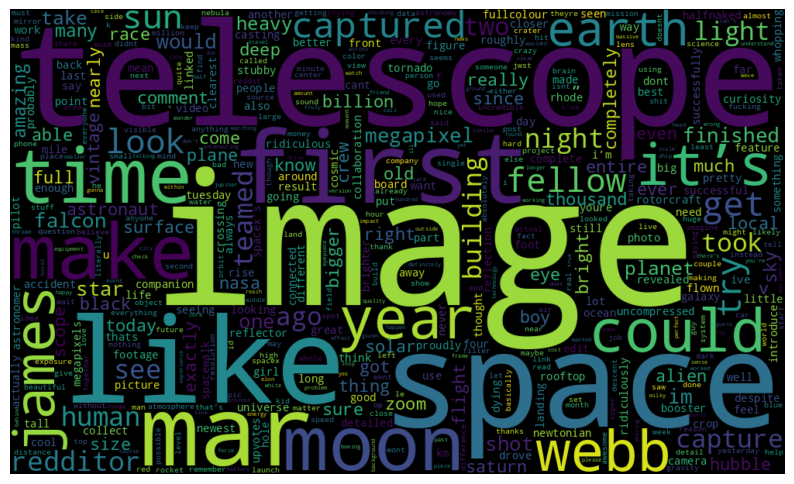

In [14]:
wc = WordCloud(width=1000, height=600, max_words=500).generate_from_frequencies(freq)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

The word cloud along with the top 10 word list can give a person a really good idea of what SubReddit was downloaded.  The most used words such as *moon*, *space*, *earth*, and *astronaut* are really good indicators of the subject under discussion.

**Vectorize Text Data**

Machine Learning algorithms do not understand text information and in order to feed text into an ML algorithm, it must be converted to numeric values.  There are a few options available to do this task.  In a past lab we used a *CountVectorizer*, which simply counts the number of times a word appears in the document.  The *TfidfVectorizer*, on the other hand, counts the words and takes into account how important that word is to the whole corpus.  I've also added parameters suggested by this article [Sparse Features](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py), since the dataset I am working with is sparse in nature.

In [15]:
tfv = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, stop_words='english')
X = tfv.fit_transform(reddit_df['content'])
X.shape

(10000, 3324)

-------------------------------------------------------------------------------
### Cluster Text with K-Means

K-Means clustering is one of the most popular unsupervised machine learning algorithms. K-Means clustering is used to find intrinsic groups within an unlabelled dataset and draw inferences from them. In this study, I will be clustering the most used words in the Reddit submissions.

K-means optimizes a non-convex objective function and its clustering is not guaranteed to be optimal for a given random init.  Furthermore, sparse high-dimensional data such as text vectorized using the *Bag of Words* approach (which I am doing in this lab), can cause k-means to initialize centroids on extremely isolated data points.  One way to avoid this problem is to increase the number of runs with independent random initiators.  Increasing the `n_init` parameter's value will do this [Sparse Features](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py).  The default for `n_init` changes depending on the value of `init`, since the default for `init` is *k-means++* the default for `n_init` is **1**

In [16]:
# Declare a list to store results in
sum_sq= []

# fit the model for a range of 1 to 11 clusters and add to sum_sq[]
for n in range (1, 11):
    print('Calculating for ',n,' clusters')
    
    # random_state makes the results more reproducible 
    km_model = KMeans(n_clusters=n, max_iter=2000, n_init=2, random_state=42)
    km_model.fit(X)
    sum_sq.append(-km_model.score(X))

Calculating for  1  clusters
Calculating for  2  clusters
Calculating for  3  clusters
Calculating for  4  clusters
Calculating for  5  clusters
Calculating for  6  clusters
Calculating for  7  clusters
Calculating for  8  clusters
Calculating for  9  clusters
Calculating for  10  clusters


One method to determine the optimal number of clusters is to plot the results of the K-Means clustering algorithm and looking for a bend in the plot.  The bend should indicate the optimal number of clusters.  This is known as the *elbow method* and the plot is known as a *scree plot*

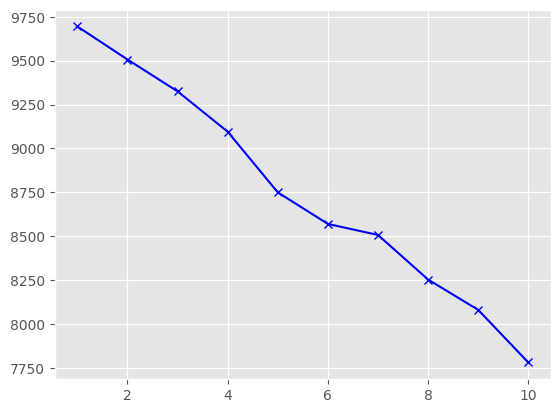

In [17]:
plt.plot(range(1, 11), sum_sq, 'bx-')
plt.show()

This plot is a little difficult to interpret.  A bend starts at 5 with a sharper change at 6. Based on the angle of the curve at 6, I'll run the model with 6 clusters.

In [18]:
# Fit the KMeans model with 6 clusters
km_model = KMeans(n_clusters=6, n_init=2, random_state=42)
km_model.fit(X)

# gather the predictions
preds = km_model.predict(X)

I will use sklearn.metrics silhouette_score to gauge the performance of 5 clusters.  The Silhouette Coefficient is calculated using the mean intra-cluster distance and the nearest-cluster distance for each sample.  The best value is 1 and the worst is -1. Values near 0 indicate overlapping clusters [sklearn.metrics.silhoulette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).  I would like to see a score close to 1.

In [19]:
score = metrics.silhouette_score(X, preds, sample_size=2000)
score

0.06248956003598066

The score is above zero, but still not very close to 1.  I will try with 5 clusters.

In [20]:
# Fit the KMeans model with 5 clusters
km_model = KMeans(n_clusters=5, n_init=2, random_state=42)
km_model.fit(X)

# gather the predictions
preds = km_model.predict(X)

In [21]:
score = metrics.silhouette_score(X, preds, sample_size=2000)
score

0.06334347033109244

The silhouette score for 5 clusters is closer to 1 than the 6 cluster model.  However, both scores are fairly close to 0 which indicates the clusters maybe overlapping.

In very high-dimensional spaces, euclidean distances tend to become inflated (curse of dimensionality). This may have happened here and to confirm I will check the inertia score. Inertia is the means of how internally coherent the clusters are. A score of zero is optimal.

In [22]:
km_model.inertia_

8750.087264438806

The score is significantly higher than zero.  I will apply an algorithm to reduce the dimensions.

-------------------------------------------------------------------------------
**Principal Component Analysis (PCA)**

It is possible the dataset had too many dimensions and this is causing the clustering algorithm to not perform as expected (*Curse of dimensionality*).  Linear dimensionality can be reduced using ***Singular Value Decomposition (SVD)***.  I will reduce the dimensions of the dataset and plot the results.

Text(0.5, 1.0, 'K-Mean Clusters after Reducing Dimensions')

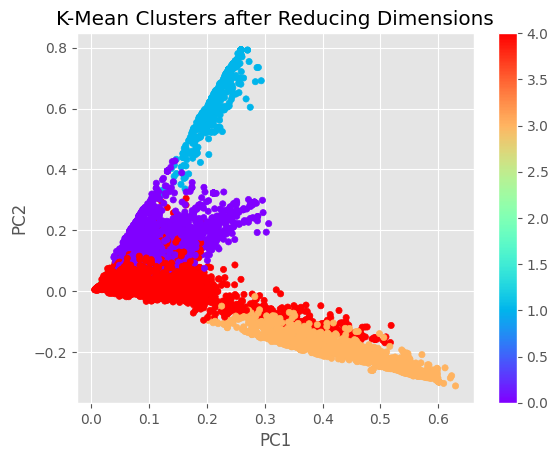

In [23]:
# Create the SVD object and reduce dataset
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
data_reduced = svd.fit_transform(X)
data_reduced = pd.DataFrame(data_reduced)

# Plot results
ax = data_reduced.plot(kind='scatter', x=0, y=1, c=preds, cmap='rainbow')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K-Mean Clusters after Reducing Dimensions')

The plot above indicates the clusters are not well defined.  Even though there is overlabp, the plot still shows 4 clusters.  There is overlap along the edges of the clusters and this confirms that the *inertia_ score* is indicating overlap.

**Hierarchical Cluster Analysis (HCA)**

**HCA** is an algorithm that can be used to make the clusters more distinct and provide better separation between them.  It works by treating each observation as a separate cluster.  Then it repeatedly executes the following two steps:
1) Identify the two clusters that are closest together
2) Merge the two most similar ones.  This continues until all the clusters are merged

**Dendrograms**

We can use a dendrogram to visualize the history of groupings and figure out the optimal number of clusters. To determine the largest vertical distance that does not intersect any of the other clusters Draw a horizontal line at both extremities The optimal number of clusters is equal to the number of vertical lines going through the horizontal line.

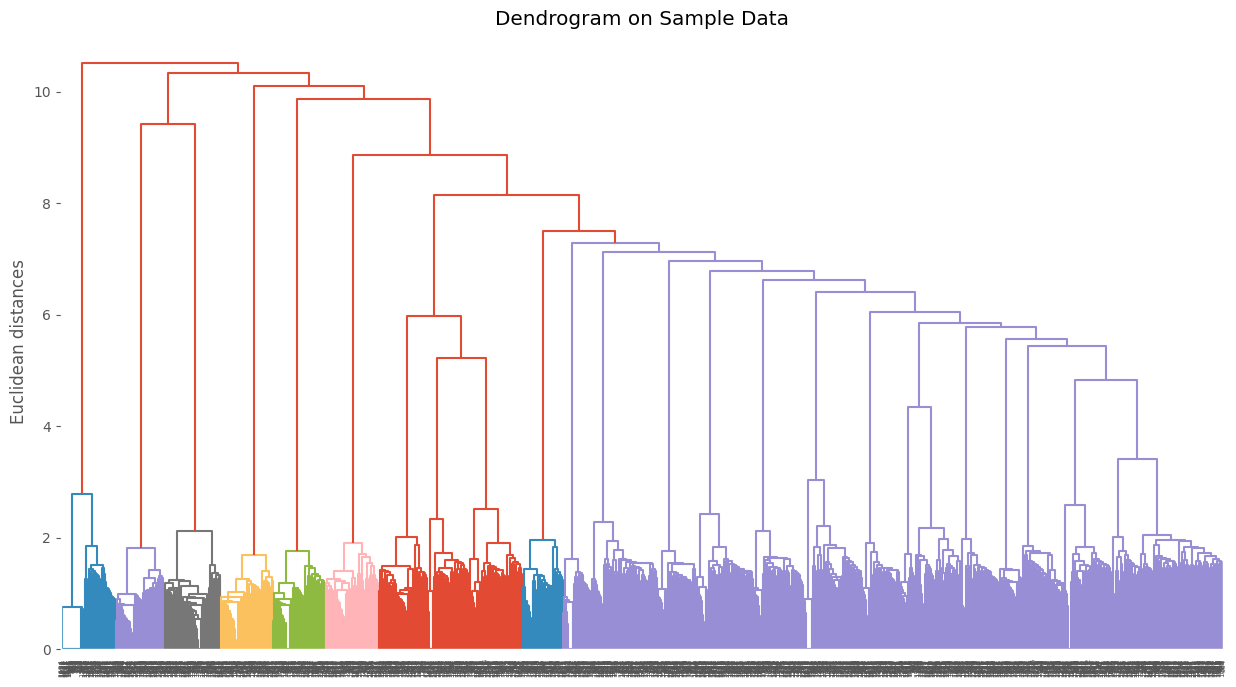

In [24]:
# I will select a sample of 2000 from the 10,000
indices = np.random.choice(X.shape[0], 2000, replace=False)
ydist = X[indices].toarray() # The linkage() method input requires an array

# The scipy hierarchial linkage method is used to create the HCA
# parameter ward instructs the method to use the Ward variance 
# minimization algorithm
Z = linkage(ydist, 'ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(Z)
plt.title('Dendrogram on Sample Data')
plt.ylabel('Euclidean distances')
plt.show()

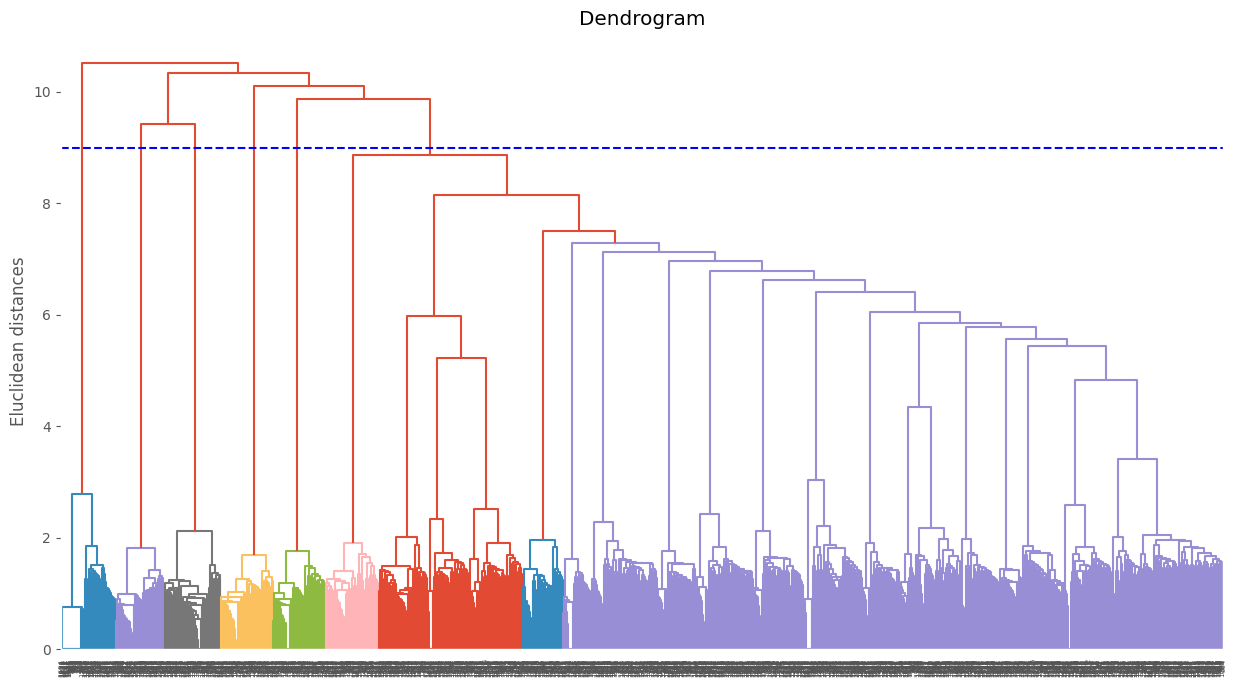

In [25]:
plt.figure(figsize=(15, 8))
dendrogram(Z)
plt.title('Dendrogram')
plt.ylabel('Eluclidean distances')
plt.axhline(y=9, color='b', linestyle='--')
plt.show()

If I understand the Lecture for Week 6 correctly, the dendrogram is indicating I should apply hierarchical clustering for 5 clusters.

I will try K-Means again with 5 clusters on the data that had PCA and HCA applied

In [28]:
# Fit the KMeans model with 5 clusters
km_model = KMeans(n_clusters=5, n_init=2, random_state=42)
km_model.fit(Z)

# gather the predictions
preds = km_model.predict(Z)
metrics.silhouette_score(Z, preds, sample_size=2000)

0.4267911730008621

Look at the *inertia_ score*

In [29]:
km_model.inertia_

526322304.61238825

The *silhouette score* shows significant improvement; therefore, the clusters are not overlapping as much as before the PCA.  Unfortunately, it looks likes the clusters are less defined after the HCA as the *inertia score* is significantly higher than before the HCA which indicates the clusters are not well defined.

-------------------------------------------------------------------------------
### Summary and Discussion
**Summary**

The goal of this lab was to download a text-based dataset from Twitter or Reddit.  I chose to download submittals from the Space subReddit.  The submitttal  and its comments had to be downloaded separately due to API limitations.  Since the relationship between a submittal and comments is a one-to-many, I saved the submittals and their comments to a *sqlite3* database file.  This allowed me to load the data into a dataframe using a *SQL* join statement.

After creating the dataframe from a SQL statement, I performed some basic data wrangling to change the timestamps from UNIX epoch to a readable format.  I also identified the sumbittal's title and the comment's body as the features of interest in this study.  As part of the data wrangling process, I also reduced the number of records in the dataset from over 300,000 to 10,000 using Pandas' head function.  Then I preprocessed all of the text features by converting all characters to lowercase, removing digits, removing punctuation, and applying a lemmatizer algorithm to reduce words to their basic forms.  I chose to lemmatize the text instead of stemming, since sklearn's *WordNetLemmatizer* actually uses a corpra (word dictionary) to look up the words being lemmatized.  The basic form of the word is know as a *lemma*.  In this case, I believe the lemmatizer reduced *Mars* to *mar*.  this maybe due to me converting everything to lowercase before applying the lemmatizer.

The features `title`, `body`, `author`, and `comment_author` were merged together into one feature named `content`. Furthermore, the `text` feature was dropped, since it did not contain any useful information.  After the merge and drop processes, some basic EDA was conducted on the feature.  This included listing the top 10 words used in the dataset and plotting a word cloud.  

Next the dataset under study was vectorized using the TfidfVectorizer function.  the TfidfVectorizer converts a collection of raw documents to a matrix of TF-IDF features.  These features were then fitted to a K-Means algorithm and a 10 step loop was constructed to iterate through different number of clusters and a score calculated to find the optimal number of clusters to use.  Using a *scree* plot and the *silhouette score*, I determined that 6 clusters were the optimal number.  However, the *silhouette* and *inertia_* scores indicated that the clusters were not well defined and the model may be suffering from the *curse of dimentionality*.  Therefore, a SVD method was applied to the dataset to reduce its linear dimensionality.  None the less, a PCA plot indicated the clusters were still not well formed and a HCA was conducted.

**Results**

The PCA process did reduce the *dimentionality* of the clusters with a significantly larger score.  This indicates the clusters are still overlapping, but not as bad as before the PCA.  The *inertia score* after HCA indicates the clusters are still not well defined and actually became less defined.

| Process                              | Silhouette | Inertia      |
|--------------------------------------|------------|--------------|
| K-Means<br> 5 Clusters                   | 0.063      | 8750.09      |
| K-Means<br> 6 Clusters                   | 0.062      | Not Recorded |
| K-Means after<br> PCA and HCA<br> 5 Clusters | 0.43      | 526322304.61  |

**Discussion**

I found that just clustering text is most likely not the best use for K-Means clustering.  However, I do think that this can be remedy by setting some categories for the clusters.  For example, try to cluster around categories such as *Earth*, *Moon*, *Mars*, and *Image*.  It would be interesting to see if K-Means could create those clusters based on analyzing the text of the submittal and its comments.